In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import logging
from model.models import Simulator
import service.regressor as regressor
import pickle


import service.files_service as fs
import csv
import datetime

2016-12-29 15:23:08,797 [ERROR]  Line magic function `%conda` not found.


In [23]:
simulator = pickle.load(open('/drive_ext4/predictions/simulator_Open_Ask_EURRUB_with_3_shifts.p','rb'))

In [24]:
ec2-54-193-2-237.us-west-1.compute.amazonaws.com


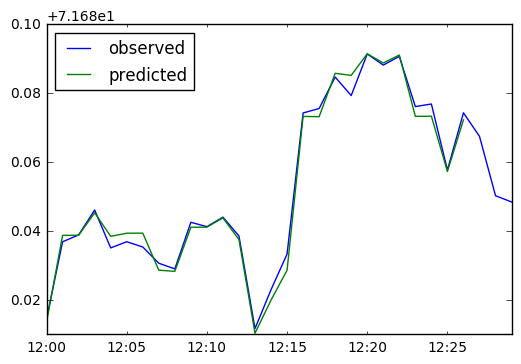

In [26]:
df_t.predicted = df_t.predicted.shift(periods=-3)
df_t.plot()

In [1]:
cols =['Open_Ask_EURRUB', 'Open_Ask_USDRUB', 'Open_Ask_USDCAD', 'Open_Ask_LIGHTCMDUSD', 'Open_Ask_USDMXN', 'Open_Ask_EURNOK', 'Open_Ask_USDNOK', 'Open_Ask_BRENTCMDUSD']

def compute(targets):
    for target in targets:
        for shift in [3,4,6,10,20,30,40,50]:
            simulator = Simulator(dt_from='2011-09-28 12:00', dt_to='2011-09-28 12:30', target=target, shift=shift,fit_model=True,
                         datasource_path='data/merged_no_spread_ultralight.csv',ticks_to_shift=[0,1,2,3,4,5,10,20,30,40,50])
            regressor.dataset(simulator)
            regressor.fit(simulator)
            regressor.predict(simulator)
            print simulator.features_weight[:10]


compute(['Open_Ask_EURRUB'])
# , u'Open_Ask_USDRUB',
#        u'Open_Ask_USDCAD', u'Open_Ask_LIGHTCMDUSD', u'Open_Ask_USDMXN',
#        u'Open_Ask_EURNOK', u'Open_Ask_USDNOK', u'Open_Ask_BRENTCMDUSD'])

2016-12-29 14:09:38,082 [INFO ]  new Simulator created
2016-12-29 14:09:38,132 [INFO ]  Start creating the dataset for Open_Ask_EURRUB
2016-12-29 14:09:38,264 [INFO ]  Finished creating the dataset for Open_Ask_EURRUB
2016-12-29 14:09:38,729 [INFO ]  Start fitting the model Targets : Open_Ask_EURRUB : [2011-09-28 12:00:00-2011-09-28 12:30:00]         ticks_to_shift:[0, 1, 2, 3, 4, 5, 10, 20, 30, 40, 50] shift:3
2016-12-29 14:09:38,861 [INFO ]  Start GridSearchCV...
2016-12-29 14:10:40,152 [INFO ]  finished  fitting via GridSearchCV


BEST PARAMS {'reg_alpha': 0.2, 'colsample_bytree': 1, 'silent': False, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.1, 'missing': None, 'max_delta_step': 0, 'nthread': -1, 'base_score': 0.5, 'n_estimators': 200, 'subsample': 1, 'reg_lambda': 1, 'seed': 0, 'min_child_weight': 1, 'objective': 'reg:linear', 'max_depth': 30, 'gamma': 0}


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [13]:
simulator_t = pickle.load(open('data/predictions/simulator_Open_Ask_EURRUB_with_3_shifts.p','rb'))

In [17]:
simulator_t.features_weight

,index,weight,feature_name
59,f11,776,Open_Ask_USDMXN_reg_shifted_4
77,f65,157,Open_Ask_USDNOK_reg_shifted_0
85,f74,139,Open_Ask_USDNOK_reg_shifted_30
65,f1,117,Open_Ask_USDMXN_reg_shifted_50
20,f20,116,Open_Ask_EURRUB_reg_shifted_40
60,f16,115,Open_Ask_USDMXN_reg_shifted_5
10,f57,115,Open_Ask_BRENTCMDUSD_reg
87,f76,111,Open_Ask_USDNOK_reg_shifted_50
37,f85,109,Open_Ask_USDCAD_reg_shifted_4
86,f75,106,Open_Ask_USDNOK_reg_shifted_40
